angle
[0.51085401 3.96954512 3.71995575 0.36022518 6.01782384 5.11382249
 5.50914197 0.42163282 5.59204823 0.12297732 3.19356666 1.08682616
 0.08198742 4.36803465 2.50639389 4.90548754 1.12535642 4.61323884
 1.67663298 2.52876846 1.83999142 2.69228353 2.37921799 2.4991855
 0.90098802 0.68965556 1.45458578 5.22975659 0.84860868 2.99260853
 2.9323231  0.52763042]
out
[[ 0.87232728  0.4889224 ]
 [-0.67638528 -0.736548  ]
 [-0.83735859 -0.54665399]
 [ 0.93581748  0.35248497]
 [ 0.96499777 -0.2622581 ]
 [ 0.39073829 -0.92050181]
 [ 0.7150901  -0.69903229]
 [ 0.91242193  0.40925082]
 [ 0.77052172 -0.63741374]
 [ 0.99244781  0.12266758]
 [-0.99864966 -0.05195061]
 [ 0.46529705  0.88515459]
 [ 0.99664091  0.0818956 ]
 [-0.33758898 -0.94129362]
 [-0.80495378  0.59333752]
 [ 0.19190078 -0.98141433]
 [ 0.4308549   0.90242122]
 [-0.09898777 -0.99508865]
 [-0.10563918  0.99440453]
 [-0.81802686  0.57518002]
 [-0.2659556   0.96398528]
 [-0.90074739  0.43434333]
 [-0.72319801  0.69064075]
 [-0.800655

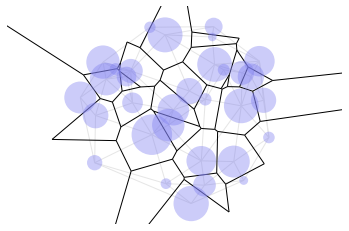

[0.58572887 0.98859503 0.37332526 0.30267618 0.2826891  0.55511412
 0.21669525 0.64316777 0.78016665 0.61512258 0.6269138  0.20697054
 0.84690433 0.79179249 0.28925639 0.86108236 0.43561146 0.26103005
 0.85321571 0.8133386  0.27639557 0.79456157 0.58695534 0.48090658
 0.63537155 0.28940488 0.76617673 0.72351016 0.84612413 0.77965538
 0.50431882 0.74388936]


In [3]:
import itertools
import numpy as np
from scipy.spatial import ConvexHull

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plot


# --- Misc. geometry code -----------------------------------------------------

'''
Pick N points uniformly from the unit disc
This sampling algorithm does not use rejection sampling.
'''


def disc_uniform_pick(N):
    angle = (2 * np.pi) * np.random.random(N)
    out = np.stack([np.cos(angle), np.sin(angle)], axis=1)
    out *= np.sqrt(np.random.random(N))[:, None]
    return out


def norm2(X):
    return np.sqrt(np.sum(X ** 2))


def normalized(X):
    return X / norm2(X)


# --- Delaunay triangulation --------------------------------------------------

def get_triangle_normal(A, B, C):
    return normalized(np.cross(A, B) + np.cross(B, C) + np.cross(C, A))


def get_power_circumcenter(A, B, C):
    N = get_triangle_normal(A, B, C)
    return (-.5 / N[2]) * N[:2]


def is_ccw_triangle(A, B, C):
    M = np.concatenate([np.stack([A, B, C]), np.ones((3, 1))], axis=1)
    return np.linalg.det(M) > 0


def get_power_triangulation(S, R):
    # Compute the lifted weighted points
    S_norm = np.sum(S ** 2, axis=1) - R ** 2
    S_lifted = np.concatenate([S, S_norm[:, None]], axis=1)

    # Special case for 3 points
    if S.shape[0] == 3:
        if is_ccw_triangle(S[0], S[1], S[2]):
            return [[0, 1, 2]], np.array([get_power_circumcenter(*S_lifted)])
        else:
            return [[0, 2, 1]], np.array([get_power_circumcenter(*S_lifted)])

    # Compute the convex hull of the lifted weighted points
    hull = ConvexHull(S_lifted)

    # Extract the Delaunay triangulation from the lower hull
    tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [
                     a, c, b] for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)

    # Compute the Voronoi points
    V = np.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])

    # Job done
    return tri_list, V


# --- Compute Voronoi cells ---------------------------------------------------

# Order the segments

def order_segment_list(segment_list):
    # Pick the first element
    first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

    # In-place ordering
    segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
    for i in range(len(segment_list) - 1):
        for j in range(i + 1, len(segment_list)):
            if segment_list[i][0][1] == segment_list[j][0][0]:
                segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
                break

    # Job done
    return segment_list


'''
Compute the segments and half-lines that delimits each Voronoi cell
  * The segments are oriented so that they are in CCW order
  * Each cell is a list of (i, j), (A, U, tmin, tmax) where
     * i, j are the indices of two ends of the segment. Segments end points are
       the circumcenters. If i or j is set to None, then it's an infinite end
     * A is the origin of the segment
     * U is the direction of the segment, as a unit vector
     * tmin is the parameter for the left end of the segment. Can be -1, for minus infinity
     * tmax is the parameter for the right end of the segment. Can be -1, for infinity
     * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
'''


def get_voronoi_cells(S, V, tri_list):
    # Keep track of which circles are included in the triangulation
    vertices_set = frozenset(itertools.chain(*tri_list))

    # Keep track of which edge separate which triangles
    edge_map = {}
    for i, tri in enumerate(tri_list):
        for edge in itertools.combinations(tri, 2):
            edge = tuple(sorted(edge))
            if edge in edge_map:
                edge_map[edge].append(i)
            else:
                edge_map[edge] = [i]

    # For each triangle
    voronoi_cell_map = {i: [] for i in vertices_set}

    for i, (a, b, c) in enumerate(tri_list):
        # For each edge of the triangle
        for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
            # Finite Voronoi edge
            edge = tuple(sorted((u, v)))
            if len(edge_map[edge]) == 2:
                j, k = edge_map[edge]
                if k == i:
                    j, k = k, j

                # Compute the segment parameters
                U = V[k] - V[j]
                U_norm = norm2(U)

                # Add the segment
                voronoi_cell_map[u].append(
                    ((j, k), (V[j], U / U_norm, 0, U_norm)))
            else:
                # Infinite Voronoi edge
                # Compute the segment parameters
                A, B, C, D = S[u], S[v], S[w], V[i]
                U = normalized(B - A)
                I = A + np.dot(D - A, U) * U
                W = normalized(I - D)
                if np.dot(W, I - C) < 0:
                    W = -W

                # Add the segment
                voronoi_cell_map[u].append(
                    ((edge_map[edge][0], -1), (D,  W, 0, np.Inf)))
                voronoi_cell_map[v].append(
                    ((-1, edge_map[edge][0]), (D, -W, -np.Inf, 0)))

    # Job done
    return {i: order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items()}


# --- Plot all the things -----------------------------------------------------

def display(S, R, tri_list, voronoi_cell_map):
    # Setup
    fig, ax = plot.subplots()
    plot.axis('equal')
    plot.axis('off')

    # Set min/max display size, as Matplotlib does it wrong
    min_corner = np.amin(S, axis=0) - np.max(R)
    max_corner = np.amax(S, axis=0) + np.max(R)
    plot.xlim((min_corner[0], max_corner[0]))
    plot.ylim((min_corner[1], max_corner[1]))

    # Plot the samples
    for Si, Ri in zip(S, R):
        ax.add_artist(plot.Circle(Si, Ri, fill=True, alpha=.4,
                      lw=0., color='#8080f0', zorder=1))

    # Plot the power triangulation
    edge_set = frozenset(tuple(sorted(edge))
                         for tri in tri_list for edge in itertools.combinations(tri, 2))
    line_list = LineCollection([(S[i], S[j])
                               for i, j in edge_set], lw=1., colors='.9')
    line_list.set_zorder(0)
    ax.add_collection(line_list)

    # Plot the Voronoi cells
    edge_map = {}
    for segment_list in voronoi_cell_map.values():
        for edge, (A, U, tmin, tmax) in segment_list:
            edge = tuple(sorted(edge))
            if edge not in edge_map:
                if tmax is np.Inf:
                    tmax = 10
                if tmin is -np.Inf:
                    tmin = -10

                edge_map[edge] = (A + tmin * U, A + tmax * U)

    line_list = LineCollection(edge_map.values(), lw=1., colors='k')
    line_list.set_zorder(0)
    ax.add_collection(line_list)

    # Job done
    plot.show()


# --- Main entry point --------------------------------------------------------

def main():
    # Generate samples, S contains circles center, R contains circles radius
    sample_count = 32
    S = 5 * disc_uniform_pick(sample_count)
    R = .8 * np.random.random(sample_count) + .2

    # Compute the power triangulation of the circles
    tri_list, V = get_power_triangulation(S, R)

    # Compute the Voronoi cells
    voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

    # Display the result
    display(S, R, tri_list, voronoi_cell_map)

if __name__ == '__main__':
    main()

In [26]:
import geopandas as gpd
import geoplot as gplt

ImportError: cannot import name '_PolygonPatch' from 'geopandas.plotting' (/opt/anaconda3/envs/TF/lib/python3.7/site-packages/geopandas/plotting.py)

In [25]:
help(geopandas.plotting)

Help on module geopandas.plotting in geopandas:

NAME
    geopandas.plotting

FUNCTIONS
    deprecated(new)
        Helper to provide deprecation warning.
    
    plot_dataframe(df, column=None, cmap=None, color=None, ax=None, cax=None, categorical=False, legend=False, scheme=None, k=5, vmin=None, vmax=None, markersize=None, figsize=None, legend_kwds=None, categories=None, classification_kwds=None, missing_kwds=None, aspect='auto', **style_kwds)
        Plot a GeoDataFrame.
        
        Generate a plot of a GeoDataFrame with matplotlib.  If a
        column is specified, the plot coloring will be based on values
        in that column.
        
        Parameters
        ----------
        df : GeoDataFrame
            The GeoDataFrame to be plotted.  Currently Polygon,
            MultiPolygon, LineString, MultiLineString and Point
            geometries can be plotted.
        column : str, np.array, pd.Series (default None)
            The name of the dataframe column, np.array

In [21]:
help(gpd.plotting._PolygonPatch)

AttributeError: module 'geopandas.plotting' has no attribute '_PolygonPatch'

In [15]:
import matplotlib.pyplot as plt
import geopandas
from cartopy import crs as ccrs

path = geopandas.datasets.get_path('naturalearth_lowres')
df = geopandas.read_file(path)
# Add a column we'll use later
df['gdp_pp'] = df['gdp_md_est'] / df['pop_est']

<AxesSubplot:>

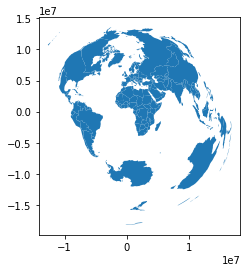

In [9]:
# Define the CartoPy CRS object.
crs = ccrs.AzimuthalEquidistant()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
df_ae = df.to_crs(crs_proj4)

# Here's what the plot looks like in GeoPandas
df_ae.plot()